In [3]:
%matplotlib inline

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from gensim.models.tfidfmodel import TfidfModel
from gensim import corpora

from wordcloud import WordCloud

### Generate Topics Corpus

In [4]:
TOPICS_DATA = pd.read_csv('../data/topics/topics_general.csv', encoding='UTF-8', index_col=0)

In [5]:
TOPICS_DATA.head()

,ID,reason,text,topic
0,2,window empty,"In addition, because none of this is associate...",topic-00
1,4,same author,yeo!,topic-00
2,5,same author,"we can share the codes `inline = rnorm(1,1,1)`...",topic-00
3,6,same author,"And, things stay in places that make sense.",topic-00
4,7,same author,There are presently two additional channels to...,topic-00


In [6]:
# Generate one document per topic
grouped = TOPICS_DATA[['topic', 'text']].groupby('topic')
documents = grouped.agg(lambda x: ' '.join( map(lambda x: x.encode('ascii', 'replace'), x) )).values.flatten()

In [7]:
STOPWORDS = set(stopwords.words('english'))  # from NLTK

# Remove common words (NLTK) and tokenize
texts = map(lambda doc: [word for word in doc.lower().split() if word not in STOPWORDS], documents)

# Generate a dictionary with the term frequency
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# remove words that appear only once
texts = map(lambda text: filter(lambda token: frequency[token] > 1, text), texts)

In [9]:
# Generate dictionary of terms
dictionary = corpora.Dictionary(texts)
# dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference

# Finally, generate the corpus
corpus = [dictionary.doc2bow(text) for text in texts]

### TF-IDF model and get each documents top words

In [12]:
tfidf = TfidfModel(corpus)

In [13]:
dictionary.get(corpus[0][0][0])

u'addresses,'

In [76]:
def get_score(document):
    ''' Generates the TF-IDF score table for each of the terms in the document '''
    return pd.DataFrame({ 'termID': map(lambda x: x[0], document),
                          'term': map(lambda x: dictionary.get(x[0]), document),
                          'score': map(lambda x: x[1], tfidf[ document ]) })[['termID', 'term', 'score']]

def get_top_terms(document, top=10):
    return get_score(document).sort_values(by='score', ascending=False)[['term', 'score']].head(top)


def score_to_int(scores):
    return map(int, 100 * scores.values / scores.min())


def prepare_wordcloud(document, top=10):
    data = get_top_terms(document, top)
    
    return [ (t, val) for t, val in zip(data.term, data.score) ]


def get_wordcloud(document, topic_name, background='#e9e9e9'):
    wordcloud = WordCloud(background_color=background)
    w = wordcloud.generate_from_frequencies( prepare_wordcloud(document) )

    plt.imshow(w.to_array())
    plt.title(topic_name, fontsize=15, fontweight='bold')
    plt.axis('off')
    plt.show()

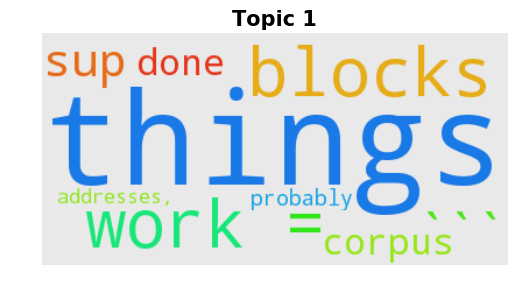

In [77]:
get_wordcloud(corpus[0], topic_name='Topic 1')

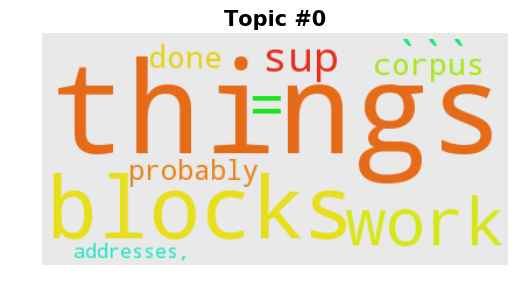

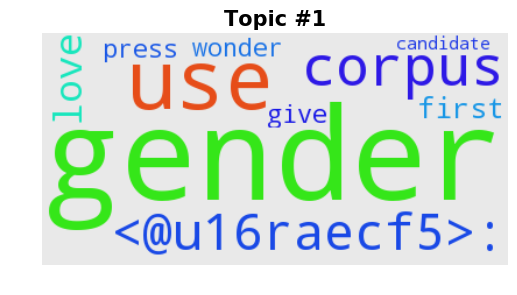

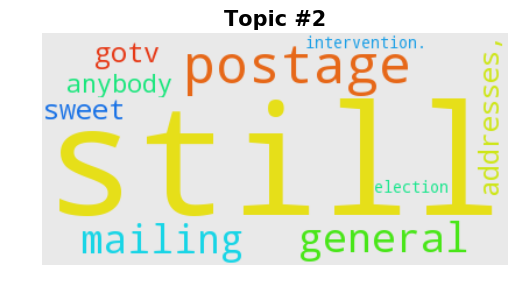

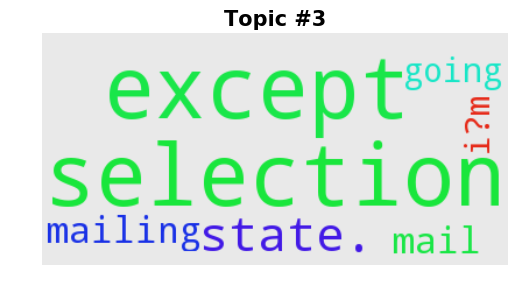

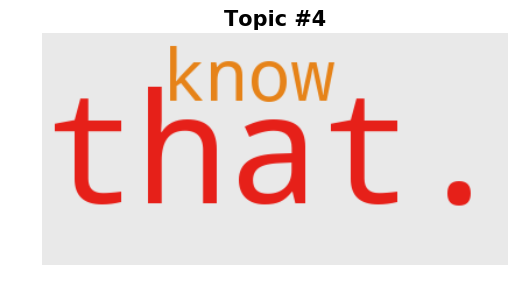

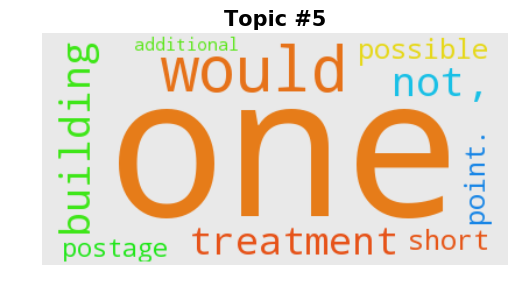

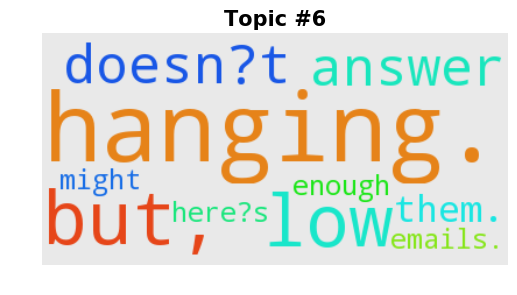

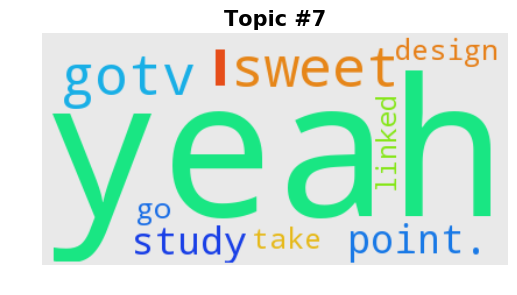

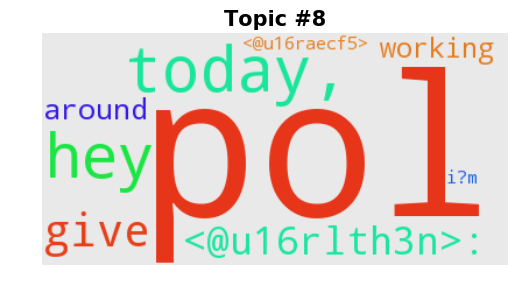

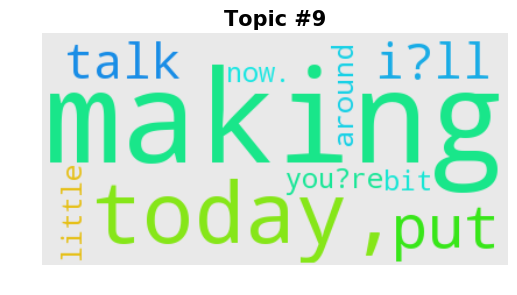

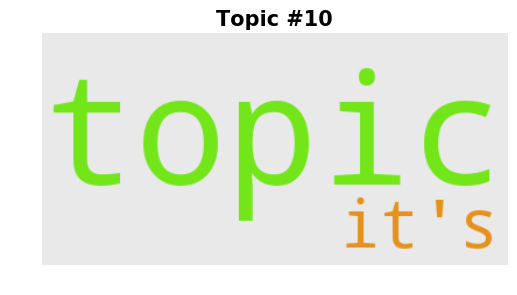

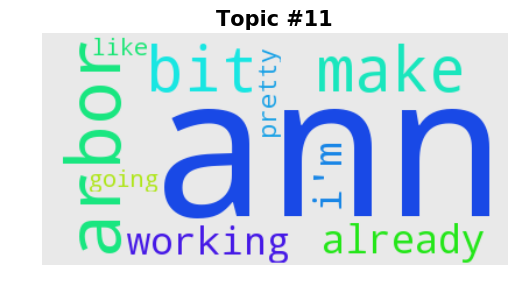

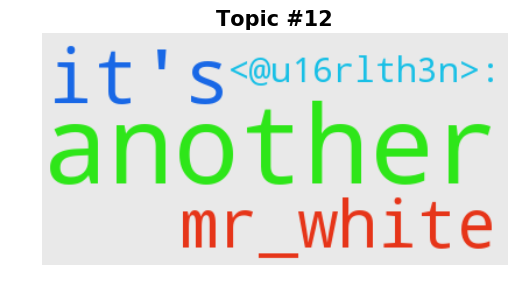

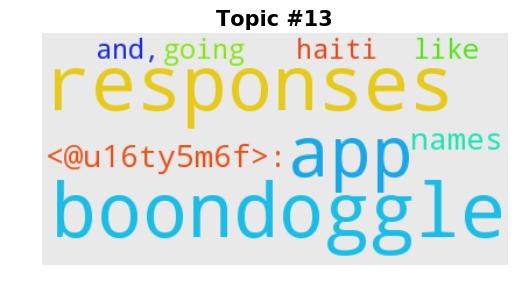

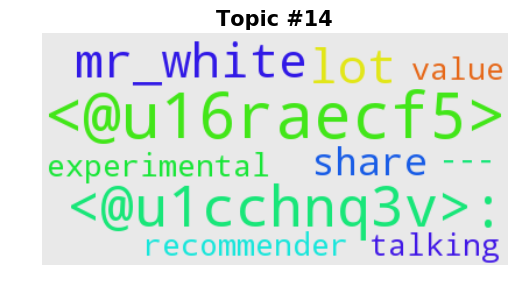

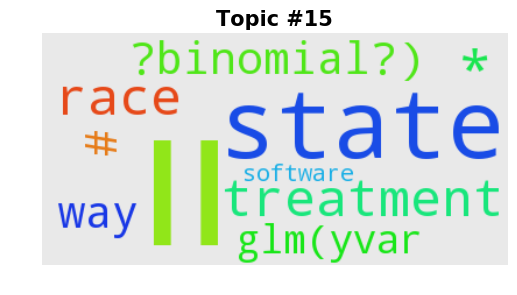

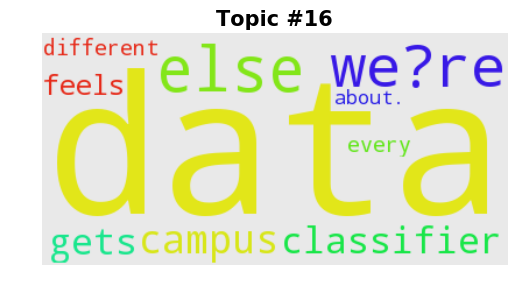

In [78]:
for i, doc in enumerate(corpus):
    get_wordcloud(doc, 'Topic #{}'.format(i))